In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking

from keras.callbacks import EarlyStopping

# map district name to district number
district_mapping_path = "../airflow/dags/data/districts.xlsx"

district_mapping = pd.read_excel(district_mapping_path)


def get_district_name(district_no):
    return district_mapping[district_mapping["Postal District"] == district_no][
        "General Location"
    ].values[0]

# Import Previous Files

In [84]:
# Import all previous files
# open pickle
train_df_dict = pd.read_pickle('data/train_df_dict.pkl')
train_df_dict_L = pd.read_pickle('data/train_df_dict_L.pkl')
test_df_dict = pd.read_pickle('data/test_df_dict.pkl')

lookback = 3

# import resale_flat_transactions_clean
resale_flat_transactions_clean = pd.read_csv('data/resale_flat_transactions_clean.csv')

# import features 
all_district_var_ts = pd.read_pickle('data/all_district_var_ts.pkl')

# replace NaN values with 0 since we are using LSTM
# Mask layer will mask the 0 values
# merge the train set with the features
train_lstm_df_dict = {}
for district_no, district_df in train_df_dict.items():
    train_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    train_lstm_df_dict[district_no] = train_lstm_df_dict[district_no].fillna(0)

train_lstm_df_dict_L = {}
for district_no, district_df in train_df_dict_L.items():
    train_lstm_df_dict_L[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')

# merge the test set with the features
test_lstm_df_dict = {}
# test_lstm_df_dict_expanded = {}
for district_no, district_df in test_df_dict.items():
    test_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # test_lstm_df_dict_expanded[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # add last {lookback} months of the train set to the test set
    # test_lstm_df_dict_expanded[district_no] = pd.concat([train_lstm_df_dict[district_no].tail(lookback), test_lstm_df_dict[district_no]])
    # replace the NaN values with 0
    test_lstm_df_dict[district_no] = test_lstm_df_dict[district_no].fillna(0)
    # test_lstm_df_dict_expanded[district_no] = test_lstm_df_dict_expanded[district_no].fillna(0)

# Normalize the data
# create scalers for each district
scaler_dict = {}
for district_no, district_df in train_lstm_df_dict.items():
    scaler_dict[district_no] = MinMaxScaler(feature_range=(-1, 1))
    scaler_dict[district_no].fit(district_df)

# create scalers for each district
scaler_dict_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    scaler_dict_L[district_no] = MinMaxScaler(feature_range=(-1, 1))
    scaler_dict_L[district_no].fit(district_df)

# transform the train set
train_lstm_df_dict_scaled = {}
for district_no, district_df in train_lstm_df_dict.items():
    train_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the train set
train_lstm_df_dict_scaled_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    train_lstm_df_dict_scaled_L[district_no] = pd.DataFrame(
        scaler_dict_L[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the test set
test_lstm_df_dict_scaled = {}
for district_no, district_df in test_lstm_df_dict.items():
    test_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# Format Data for LSTM

In [85]:
# convert all data 

from keras.preprocessing.sequence import TimeseriesGenerator

lookback = 3
num_features = len(train_lstm_df_dict_scaled[1].columns)

# create dataset for each district
train_lstm_dataset_dict = {}
for district_no, district_df in train_lstm_df_dict_scaled.items():
    train_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
train_lstm_dataset_dict_L = {}
for district_no, district_df in train_lstm_df_dict_scaled_L.items():
    train_lstm_dataset_dict_L[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
test_lstm_dataset_dict = {}
for district_no, district_df in test_lstm_df_dict_scaled.items():
    test_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)
    # add the last {lookback} months of the train set to the test set
    # print('before', len(test_lstm_dataset_dict[district_no]))
    # train_last = train_lstm_df_dict_scaled[district_no][-lookback:]
    # print('train_last shape', train_last.shape)
    # test_lstm_dataset_dict[district_no].data = np.concatenate(
    #     (train_last.values, test_lstm_dataset_dict[district_no].data), axis=0
    # )
    # print('np after', (np.concatenate(
    #     (train_last.values, test_lstm_dataset_dict[district_no].data), axis=0
    # )).shape)
    # print('after', len(test_lstm_dataset_dict[district_no]))


In [86]:
# check generator dimensions
for i in range(len(test_lstm_dataset_dict[1])):
    x, y = test_lstm_dataset_dict[1][i]
    print(x.shape, y.shape)
print(len(test_lstm_dataset_dict[1]))

len(test_lstm_df_dict_scaled[1])

(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
21


24

# LSTM Model on Keras example on district 1

In [119]:
def fit_lstm(train):
    model = Sequential()
    model.add( 
        Masking(
            mask_value=0.,
            input_shape=(
                lookback,
                num_features,
            ),
        )
    ) # mask the 0 values
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(
        train,
        epochs=100,
        batch_size=8,
        verbose=1,
    )

    return model



model_1 = fit_lstm(train_lstm_dataset_dict[1])


Epoch 1/100


2023-04-03 22:55:49.739893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 22:55:50.346452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 22:55:50.585337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 22:55:50.876989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 22:55:51.158489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 6s 41ms/step - loss: 0.5809
Epoch 2/100
36/36 [==============================] - 1s 30ms/step - loss: 0.5584
Epoch 3/100
36/36 [==============================] - 1s 34ms/step - loss: 0.5546
Epoch 4/100
36/36 [==============================] - 1s 30ms/step - loss: 0.5464
Epoch 5/100
36/36 [==============================] - 1s 31ms/step - loss: 0.5459
Epoch 6/100
36/36 [==============================] - 1s 29ms/step - loss: 0.5459
Epoch 7/100
36/36 [==============================] - 1s 27ms/step - loss: 0.5457
Epoch 8/100
36/36 [==============================] - 1s 28ms/step - loss: 0.5425
Epoch 9/100
36/36 [==============================] - 1s 32ms/step - loss: 0.5423
Epoch 10/100
36/36 [==============================] - 1s 28ms/step - loss: 0.5397
Epoch 11/100
36/36 [==============================] - 1s 27ms/step - loss: 0.5451
Epoch 12/100
36/36 [==============================] - 1s 27ms/step - loss: 0.5438
Epoch 13/100
36/36 [=================

## Get predictions and plot

In [120]:
# get the predictions
predictions = model_1.predict(test_lstm_dataset_dict[1])

print(predictions.shape) 
# number of predictions is 3 less than the number of test data because of the lookback. 
# This means that the predictions needs to be shifted by 3 months

# pad the predictions with 0 
predictions_padded = np.zeros((len(predictions), num_features)) # add dimension for the number of features
predictions_padded[:, 0] = predictions[:, 0] # fill the first column with the predictions

# inverse transform the predictions
predictions_inversed = scaler_dict[1].inverse_transform(predictions_padded) # correct shape for inverse transform

print(test_lstm_df_dict_scaled[1].shape) # test data shape


2023-04-03 22:57:38.624213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 22:57:39.039984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 22:57:39.175837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 17ms/step
(21, 1)
(24, 9)


In [121]:
def evaluate_lstm(model, X_train, X_test, district_no, lookback):
    # make predictions
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    # pad the predictions
    yhat_train_padded = np.zeros((len(yhat_train), num_features))
    yhat_train_padded[:, 0] = yhat_train[:, 0]
    yhat_test_padded = np.zeros((len(yhat_test), num_features))
    yhat_test_padded[:, 0] = yhat_test_padded[:, 0]
    
    # inverse transform the predictions
    yhat_train_inversed = scaler_dict[district_no].inverse_transform(yhat_train_padded)
    yhat_test_inversed = scaler_dict[district_no].inverse_transform(yhat_test_padded)
    print("yhat train shape", yhat_train_inversed.shape)
    print("yhat test shape", yhat_test_inversed.shape)

    # take values only
    yhat_train_inversed = yhat_train_inversed[:, 0] 
    yhat_test_inversed = yhat_test_inversed[:, 0]

    # ground truth
    y_train = train_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    y_test = test_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    print("y train shape", y_train.shape)
    print("y test shape", y_test.shape)

    train_score = math.sqrt(mean_squared_error(y_train, yhat_train_inversed))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = math.sqrt(mean_squared_error(y_test, yhat_test_inversed))
    print('Test Score: %.2f RMSE' % (test_score))

    # set index of the predictions 
    yhat_train_df = pd.DataFrame(yhat_train_inversed, index=train_lstm_df_dict[1].index[lookback:])
    yhat_test_df = pd.DataFrame(yhat_test_inversed, index=test_lstm_df_dict[1].index[lookback:])

    # plot baseline and predictions
    plt.plot(train_lstm_df_dict[district_no]['resale_price'], label="y_train", marker='o')
    plt.plot(test_lstm_df_dict[district_no]['resale_price'], label="y_test", marker='o')
    plt.plot(yhat_train_df, label="yhat_train", marker='o')
    plt.plot(yhat_test_df, label="yhat_test", marker='o')
    plt.legend()
    plt.show()

    return test_score


21/21 [==============================] - 0s 11ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 181419.64 RMSE
Test Score: 168827.23 RMSE


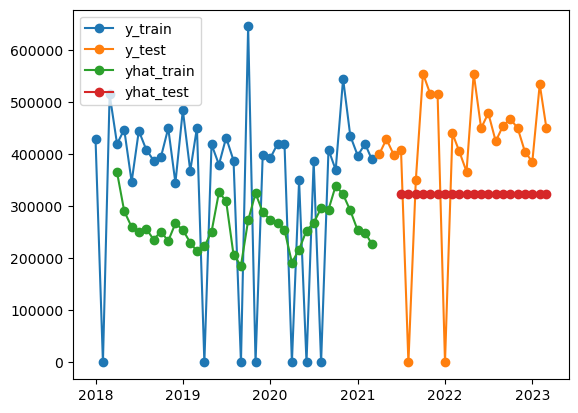

168827.22536311945

In [122]:
evaluate_lstm(
    model=model_1,
    X_train=train_lstm_dataset_dict[1],
    X_test=test_lstm_dataset_dict[1],
    district_no=1,
    lookback=3,
)
